In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit

For rough terrain,
$$
\nabla \cdot (T\,\nabla u) = \nabla \cdot \left(T\frac{\partial u}{\partial x} \hat{x} + T\frac{\partial u}{\partial y} \hat{y} \right)\\ = \frac{\partial}{\partial x}\left(T\frac{\partial u}{\partial x}\right)  + \frac{\partial}{\partial y}\left(T\frac{\partial u}{\partial y}\right)\\
= \frac{\partial T}{\partial x}\frac{\partial u}{\partial x} + T\frac{\partial^2 u}{\partial x^2} + \frac{\partial T}{\partial y}\frac{\partial u}{\partial y} + T\frac{\partial^2 u}{\partial y^2}\\
= T\,\nabla^2 u + \frac{\partial T}{\partial x}\frac{\partial u}{\partial x} + \frac{\partial T}{\partial y}\frac{\partial u}{\partial y}
$$

Now consider only the $x$ coordinate. We can approximate for a fixed $y$,
$$
\frac{\partial T}{\partial x}\frac{\partial u}{\partial x} \approx \frac{T(x-dx)[u(x-dx)-u(x)] + T(x+dx)[u(x+dx)-u(x)]}{2\,dx^2}\\
T\,\nabla^2 u \approx \frac{u(x-dx)-2u(x)+u(x+dx)}{2\,dx^2}T(x)
$$

Hence, the full diverge term becomes for a fixed $t$

$$
\nabla \cdot (T\,\nabla u)|_{(x,y)} = \frac{1}{2\,dx^2} \left\{ T(x,y) [u(x-dx,y)+u(x+dx,y)+u(x,y-dy)+u(x,y+dy)-4u(x,y)]  + \\ T(x-dx,y)[u(x-dx,y)-u(x,y)] + T(x+dx,y)[u(x+dx,y)-u(x,y)] +\\
T(x,y-dx)[u(x,y-dx)-u(x,y)]+T(x,y+dx)[u(x,y+dx)-u(x,y)]\right\}
$$

Initialise space grid with random spawns

In [4]:
n = 100
i = 5
coords = np.array([(np.random.randint(i, n-i), np.random.randint(i, n-i)) for _ in range (50)])
init_population = np.zeros((n, n))
for x, y in coords:
    init_population[x,y] = 2

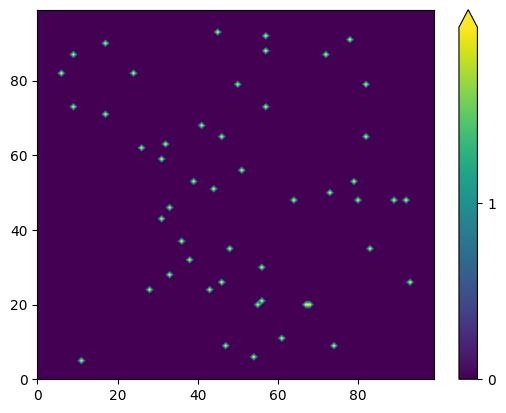

In [3]:
fig,ax = plt.subplots()
vmin,vmax = int(np.min(init_population)), int(np.max(init_population))
contourf_ = ax.contourf(init_population, levels=np.linspace(vmin,vmax,400),extend='max')
cbar = fig.colorbar(contourf_,ticks=range(vmin, vmax))

In [22]:
def gauss2d(x, y, cx=0.5, cy=0.5):
    # gaussian in domain [0,1]x[0,1]
    z = np.exp(-(x-cx)**2-(y-cy)**2)
    return z

def gauss2d_hill(x, y, cx=0.5, cy=0.5):
    # gaussian in domain [0,1]x[0,1]
    z = 1-np.exp(-(x-cx)**2-(y-cy)**2)
    return z

def twohills(x, y, cx=0.5, cy=0.5):
    # gaussian in domain [0,1]x[0,1]
    z = 1-np.exp((-(x-cx)**2-(y-cy)**2)/0.15)-np.exp((-(x-0.8)**2-(y-0.7)**2)/0.1)
    return z

def terrain2_fn(x,y):
    return np.sin(2*x*y)+1

def terrain3_fn(x,y):
    return np.sin((x+3)*(y-0.5)**2)

create rough terrain

In [10]:
terrain = np.zeros((n,n))
X    = np.linspace(0, 1, n)
Y    = np.linspace(0, 1, n)
X, Y = np.meshgrid(X, Y)

D = terrain3_fn(X,Y)

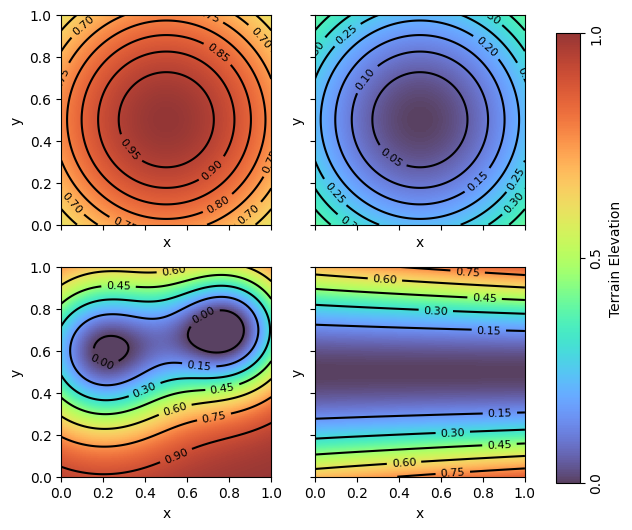

In [23]:
terrain = np.zeros((n,n))
X    = np.linspace(0, 1, n)
Y    = np.linspace(0, 1, n)
X, Y = np.meshgrid(X, Y)

terrain1 = gauss2d(X,Y)
terrain2 = gauss2d_hill(X,Y)
terrain3 = twohills(X,Y, cx=0.2, cy=0.6)
terrain4 = terrain3_fn(X,Y)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6,6), sharey=True, sharex=True)

terrains = [terrain1, terrain2, terrain3, terrain4]
for ax, terrain in zip(axes.flat, terrains):
    terrain_contour = ax.contour(X,Y,terrain,colors='black')
    ax.clabel(terrain_contour, inline=True, fontsize=8)
    color = ax.imshow(terrain, extent=[0, 1, 0, 1], origin='lower', cmap='turbo', alpha=0.8, vmax=1, vmin=0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

cax = fig.add_axes([0.95, 0.1, 0.04, 0.75])
cbar = fig.colorbar(color, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Terrain Elevation')
cbar.ax.set_yticks(ticks=np.linspace(1,0,3))
cbar.ax.set_yticklabels(np.linspace(1,0,3), rotation='vertical', va='center')
# plt.tight_layout()
plt.savefig(f'plots/5c/terrains.png', bbox_inches='tight')
plt.show()

Set the dimensions of the problem

In [6]:
x = 1
dx = 0.05
dt = 0.0001

In [7]:
total_time = 20 # sec
times = 36000*5#int(total_time/dt
times_snapshot = 3600
f = int(times/times_snapshot)
population_frames = np.zeros([times_snapshot, 100, 100])
population_frames[0] = init_population
population_size = np.zeros(times)

* Number of differential equation update iterations `times`
* Number of snapshots we will take `times_snaphot`. 
* The array of snapshots we will take of the turkey


In [8]:
print(f'Snapshot taken every {f}th frame.')
print(f'Total time of simulation is {times*dt} sec.')
print(f'Snapshot taken every {f*dt} sec.')

Snapshot taken every 50th frame.
Total time of simulation is 18.0 sec.
Snapshot taken every 0.005 sec.


Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [9]:
np.max(D * dt / dx**2)

0.033658839392315856

Set up `numba` function

In [21]:
@numba.jit("(f8[:,:,:], f8, f8, f8)", nopython=True, nogil=True, fastmath = True)
def solve_heat(environment, K, r, h):
    cs = environment[0].copy() #current state
    length = len(cs[0])
    size = np.zeros(times)
    size[0] = np.sum(cs)
    cf = 0 # current frame
    for t in range(1, times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                # tr = D[j,i]
                growth = (r-h)*cs[j][i] - (r*cs[j][i]**2)/K
                diffusion = (1/2*dx**2)* (D[j,i] *(cs[j, i-1]+cs[j, i+1]+cs[j-1,i]+cs[j+1,i]-4*cs[j,i]) +\
                                         D[j-1,i]*(cs[j-1,i]-cs[j,i])+\
                                         D[j+1,i]*(cs[j+1,i]-cs[j,i])+\
                                         D[j,i-1]*(cs[j,i-1]-cs[j,i])+\
                                         D[j,i+1]*(cs[j,i+1]-cs[j,i]))
                ns[j][i] = cs[j][i] + dt*(growth + diffusion)
                
        ns[:,0] = ns[:,1] # left neumann
        ns[:,-1] = ns[:,-2] # right neumann
        ns[0,:] = ns[1,:] # top neumann
        ns[-1,:] = ns[-2,:] # bottom neumann
        
        size[t] = np.sum(cs)
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            environment[cf] = cs
            
    return environment, size

359.3358232394004

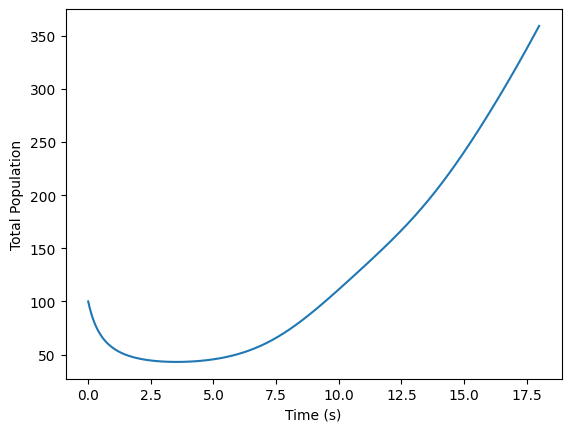

In [22]:
K, r, h = 1, 0.9, 0.2
population_frames, population_sizes = solve_heat(population_frames, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
population_sizes[-1]

Get population snapshots and population size over time plot

5554.513369697318

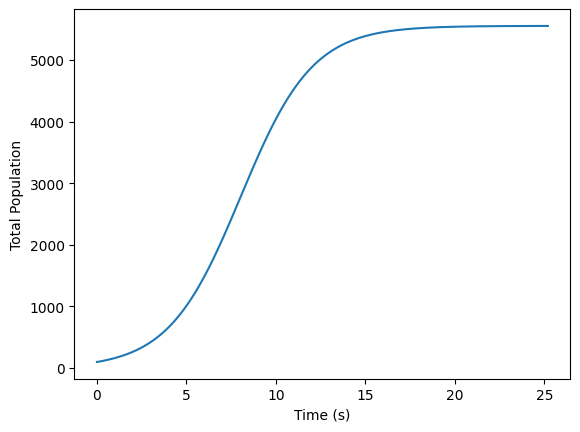

In [ ]:
K, r, h = 1, 0.9, 0.2
population_frames, population_sizes = solve_heat(population_frames, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')
population_sizes[-1]

The final snapshot

In [16]:
my_cmap = plt.get_cmap('inferno')
# plt.figure(figsize=(8,8))
# vmax=population_sizes[-1]/1e4
# a = plt.contourf(population_frames[-1], 100, levels=np.linspace(0,vmax,50), cmap=my_cmap)
# plt.colorbar(a)

In [ ]:
np.save(f'modelled data/hunting/rough_range_v2', population_frames)

Make animation

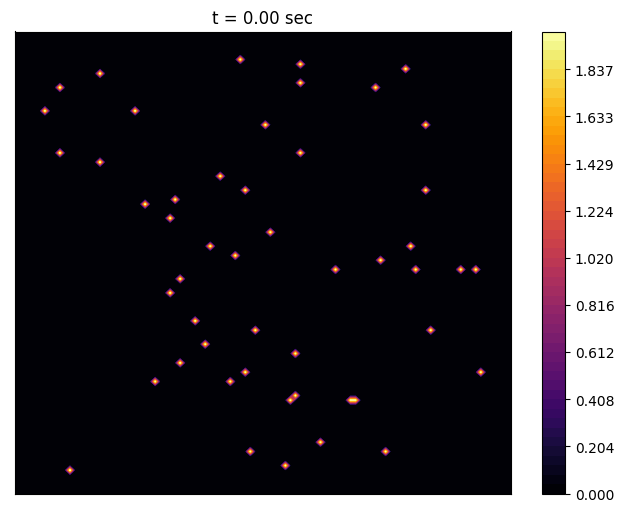

In [20]:
def animate(i):
    ax.clear()
    ax.contourf(population_frames[10*i], 100, levels=np.linspace(0,vmax,50), cmap=my_cmap) #put vmin and vmax
    plt.title(f't = {10*i*f*dt:.2f} sec')
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    return fig,

fig, ax = plt.subplots(figsize=(8,6))
a = ax.contourf(population_frames[0], 100, levels=np.linspace(0,vmax,50), cmap=my_cmap) #put vmin and vmax
fig.colorbar(a, ax=ax)
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('population_rough_range_v0.gif',writer='pillow',fps=30)

# Plotting functions

In [7]:
compare_sizes = {} 
my_cmap = plt.get_cmap('inferno')

In [37]:
loc = 'modelled data/hunting'
name='rough3.txt'
modelled_frames = np.load(f'{loc}/{name}.npy')

In [38]:
compare_sizes[name] = np.array([np.average(modelled_frames[i]) for i in range(0, 3600, 2)])

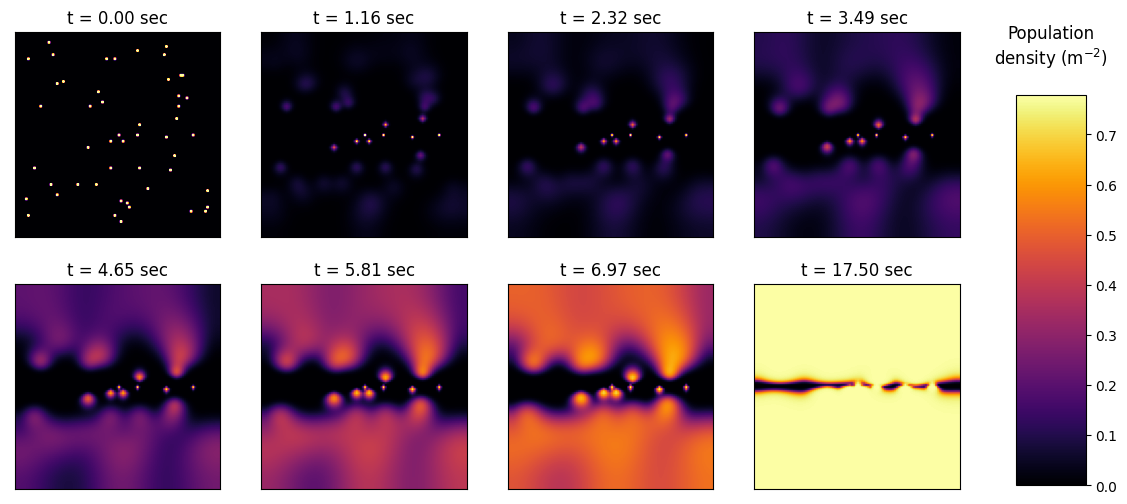

In [39]:
show_frame_id = [int(1500/9)*i for i in range(0, 8)]
fig, ax = plt.subplots(figsize=(14,6))
vmax = np.max(modelled_frames[-1])

for i in range(len(show_frame_id)):
    plt.subplot(240 + i + 1, anchor='C')
    im = plt.imshow(modelled_frames[show_frame_id[i]], cmap=my_cmap, vmin=0, vmax=vmax)
    plt.xticks([]), plt.yticks([])
    plt.title(f't = {f*dt*show_frame_id[i]:.2f} sec')

im = plt.imshow(modelled_frames[2500], cmap=my_cmap, vmin=0, vmax=vmax)
plt.title(f't = {f*dt*2500:.2f} sec')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.84, 0.12, 0.05, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.title('Population\ndensity'+r' (m$^{-2})$'+'\n')
plt.savefig(f'plots/5c/{name}_spread.png', bbox_inches='tight')
plt.show()

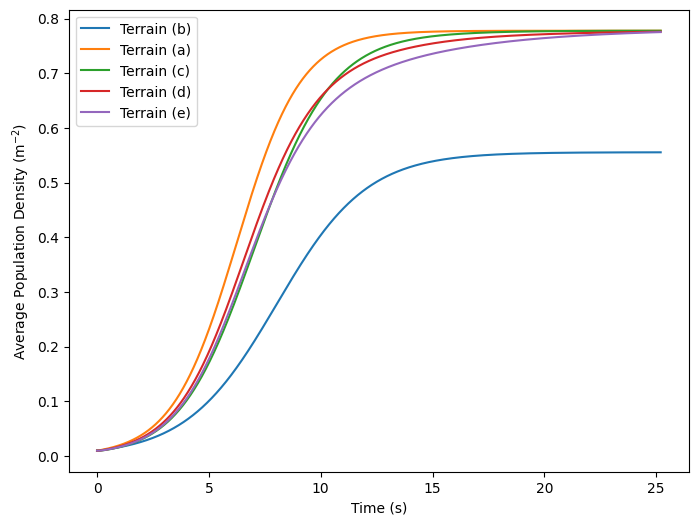

In [ ]:
labels = {
    'rough_gauss': 'Terrain (a)',
    'rough_gauss_r4': 'Terrain (b)',
    'rough_gausshill.txt': 'Terrain (c)',
    'rough_offcenter.txt': 'Terrain (d)',
    'rough3.txt': 'Terrain (e)',
}
plt.figure(figsize=(8,6))
for model in compare_sizes:
    plt.plot(np.linspace(0, times*dt, 1800), compare_sizes[model], label=labels[model])

plt.xlabel('Time (s)')
plt.ylabel(r'Average Population Density (m$^{-2}$)')
plt.legend()
plt.savefig(f'plots/5c/all_sizes.png', bbox_inches='tight')